# End to End Diabetes Machine Learning Pipeline I

* 1. Exploratory Data Analysis 
* 2. Data Preprocessing & Feature Engineering 
* 3. Base Models 
* 4. Automated Hyperparameter Optimization 
* 5. Stacking & Ensemble Learning 
* 6. Prediction for a New Observation 
* 7. Pipeline Main Function 

In [1]:
import joblib 
import pandas as pd 
from lightgbm import LGBMClassifier 
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier,AdaBoostClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_validate,GridSearchCV 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import StandardScaler 
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier 
from xgboost import XGBClassifier 

In [2]:
pd.set_option('display.max_columns',None) 
pd.set_option('display.width',500)

In [3]:
df = pd.read_csv("C:/Users/tolga/OneDrive/Masaüstü/ML_YAZ_KAMPI/Machine Learning/datasets/diabetes.csv")

1. Exploratory Data Analysis

In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [5]:
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0  33.6                     0.627   50        1
1            1       85             66             29        0  26.6                     0.351   31        0
2            8      183             64              0        0  23.3                     0.672   32        1
3            1       89             66             23       94  28.1

In [6]:
# cat_summary 

def cat_sum(dataframe, colName, plot=False):
    print(pd.DataFrame({colName: dataframe[colName].value_counts(),
                        "Ratio": 100 * dataframe[colName].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[colName], data=dataframe)
        plt.show(block=True)

In [7]:
# num_summary 
def num_summary(dataframe, numericalCol, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numericalCol].describe(quantiles).T)

    if plot:
        dataframe[numericalCol].hist(bins=20)
        plt.xlabel(numericalCol)
        plt.title(numericalCol)
        plt.show(block=True)


In [8]:
# target_summary_with_num 

def target_summary_with_num(dataframe, target, numericalCol):
    print(dataframe.groupby(target).agg({numericalCol: "mean"}), end="\n\n\n")

In [9]:
# target_summary_with_cat 

def target_summary_with_cat(dataframe, target, categoricalCol):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categoricalCol)[target].mean()}), end="\n\n\n")



In [10]:
# correlation matrix 

def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

In [11]:
# grab_col_names 

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.
    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri
    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi
    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))
    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [12]:
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0  33.6                     0.627   50        1
1            1       85             66             29        0  26.6                     0.351   31        0
2            8      183             64              0        0  23.3                     0.672   32        1
3            1       89             66             23       94  28.1

In [13]:
# değişken türlerinin ayrıştırılması 

cat_cols,num_cols,cat_but_car = grab_col_names(df,cat_th=5,car_th=20)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [14]:
cat_cols

['Outcome']

In [15]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [16]:
cat_but_car

[]

In [17]:
# kategorik değişkenlerin incelenmesi 

for col in cat_cols: 
    cat_sum(df,col)

   Outcome      Ratio
0      500  65.104167
1      268  34.895833
##########################################


In [18]:
# sayısal değişkenlerin incelenmesi 

df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


count    768.000000
mean       3.845052
std        3.369578
min        0.000000
5%         0.000000
10%        0.000000
20%        1.000000
30%        1.000000
40%        2.000000
50%        3.000000
60%        4.000000
70%        5.000000
80%        7.000000
90%        9.000000
95%       10.000000
99%       13.000000
max       17.000000
Name: Pregnancies, dtype: float64


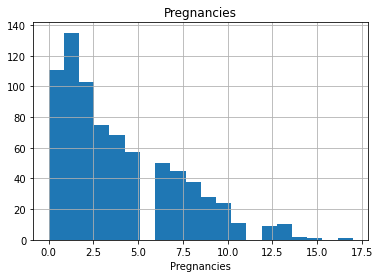

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
5%        79.000000
10%       85.000000
20%       95.000000
30%      102.000000
40%      109.000000
50%      117.000000
60%      125.000000
70%      134.000000
80%      147.000000
90%      167.000000
95%      181.000000
99%      196.000000
max      199.000000
Name: Glucose, dtype: float64


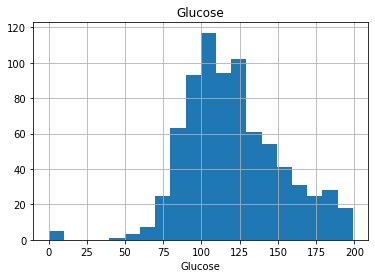

count    768.000000
mean      69.105469
std       19.355807
min        0.000000
5%        38.700000
10%       54.000000
20%       60.000000
30%       64.000000
40%       68.000000
50%       72.000000
60%       74.000000
70%       78.000000
80%       82.000000
90%       88.000000
95%       90.000000
99%      106.000000
max      122.000000
Name: BloodPressure, dtype: float64


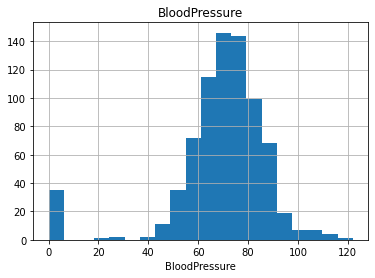

count    768.000000
mean      20.536458
std       15.952218
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        8.200000
40%       18.000000
50%       23.000000
60%       27.000000
70%       31.000000
80%       35.000000
90%       40.000000
95%       44.000000
99%       51.330000
max       99.000000
Name: SkinThickness, dtype: float64


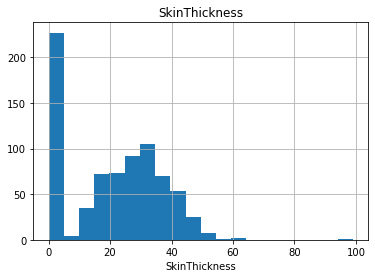

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        0.000000
40%        0.000000
50%       30.500000
60%       72.200000
70%      106.000000
80%      150.000000
90%      210.000000
95%      293.000000
99%      519.900000
max      846.000000
Name: Insulin, dtype: float64


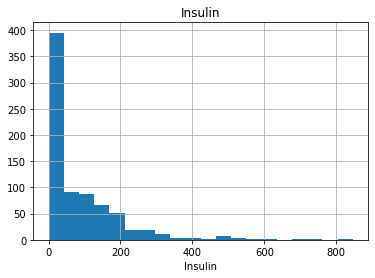

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
5%        21.800000
10%       23.600000
20%       25.900000
30%       28.200000
40%       30.100000
50%       32.000000
60%       33.700000
70%       35.490000
80%       37.800000
90%       41.500000
95%       44.395000
99%       50.759000
max       67.100000
Name: BMI, dtype: float64


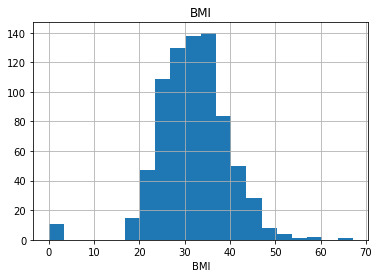

count    768.000000
mean       0.471876
std        0.331329
min        0.078000
5%         0.140350
10%        0.165000
20%        0.219400
30%        0.259000
40%        0.302800
50%        0.372500
60%        0.454200
70%        0.563700
80%        0.687000
90%        0.878600
95%        1.132850
99%        1.698330
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64


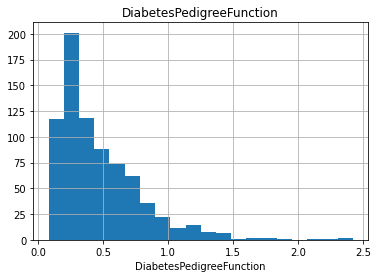

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
5%        21.000000
10%       22.000000
20%       23.000000
30%       25.000000
40%       27.000000
50%       29.000000
60%       33.000000
70%       38.000000
80%       42.600000
90%       51.000000
95%       58.000000
99%       67.000000
max       81.000000
Name: Age, dtype: float64


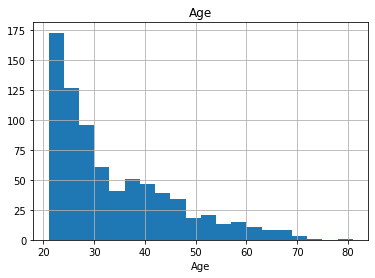

In [19]:
# grafiğini oluşturmak istersek,num_cols 
import matplotlib.pyplot as plt

for col in num_cols: 
    num_summary(df,col,plot=True)

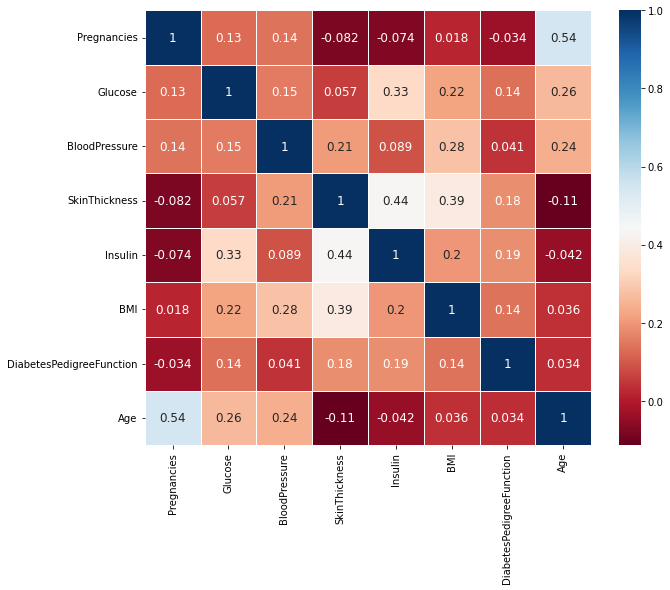

In [20]:
# sayısal değişkenlerin birbirleri ile korelasyonu
import seaborn as sns 
correlation_matrix(df,num_cols)

In [21]:
# target ile sayısal değişkenlerin incelenmesi 
# ortalaması alınıyor 
for col in num_cols: 
    target_summary_with_num(df,"Outcome",col)

         Pregnancies
Outcome             
0           3.298000
1           4.865672


            Glucose
Outcome            
0        109.980000
1        141.257463


         BloodPressure
Outcome               
0            68.184000
1            70.824627


         SkinThickness
Outcome               
0            19.664000
1            22.164179


            Insulin
Outcome            
0         68.792000
1        100.335821


               BMI
Outcome           
0        30.304200
1        35.142537


         DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500


               Age
Outcome           
0        31.190000
1        37.067164




Data Pre-Processing (Veri Ön işleme)

In [22]:
#görevi : kendisine gelen değişkenleri alt ve üst sınır tanımlar 
# ön tanımlı değerleri : q1: 0.25 , q3: 0.75
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [23]:
# aykırı değeri gönder yerine bunu koy dersek kullanırız

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [24]:
# aykırıı değer var mı yok mu ? 

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [25]:
# yeni türettiğimiz değişkenlerde kategorik değişkenleri ortaya çıkarmak için 
# dummy değişken tuzağından kurtulmak istiyoruz 

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [26]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [27]:
# değişken isimlerini büyütmek 

df.columns = [col.upper() for col in df.columns]

In [28]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [29]:
# yeni değişkenler oluşturmak istiyorum 
# Glucose 
# 0 ı da kapsasın diye -1 yazdık
df['NEW_GLUCOSE_CAT'] = pd.cut(x=df['GLUCOSE'], bins=[-1,139,200], labels=["normal","prediabetes"])


In [30]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE_CAT
0,6,148,72,35,0,33.6,0.627,50,1,prediabetes
1,1,85,66,29,0,26.6,0.351,31,0,normal
2,8,183,64,0,0,23.3,0.672,32,1,prediabetes
3,1,89,66,23,94,28.1,0.167,21,0,normal
4,0,137,40,35,168,43.1,2.288,33,1,normal


In [31]:
# age 

df.loc[(df['AGE'] < 35),"NEW_AGE_CAT"] = 'young' 
df.loc[(df['AGE'] >= 35) & (df['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage' 
df.loc[(df['AGE'] > 55),"NEW_AGE_CAT"] = 'old'

In [32]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE_CAT,NEW_AGE_CAT
0,6,148,72,35,0,33.6,0.627,50,1,prediabetes,middleage
1,1,85,66,29,0,26.6,0.351,31,0,normal,young
2,8,183,64,0,0,23.3,0.672,32,1,prediabetes,young
3,1,89,66,23,94,28.1,0.167,21,0,normal,young
4,0,137,40,35,168,43.1,2.288,33,1,normal,young


In [33]:
#BMI 
df['NEW_BMI_RANGE'] = pd.cut(x=df['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100],
                             labels=["underweight", "healty", "overweight", "obese"])


In [34]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE_CAT,NEW_AGE_CAT,NEW_BMI_RANGE
0,6,148,72,35,0,33.6,0.627,50,1,prediabetes,middleage,obese
1,1,85,66,29,0,26.6,0.351,31,0,normal,young,overweight
2,8,183,64,0,0,23.3,0.672,32,1,prediabetes,young,healty
3,1,89,66,23,94,28.1,0.167,21,0,normal,young,overweight
4,0,137,40,35,168,43.1,2.288,33,1,normal,young,obese


In [35]:
# BloodPressure 

df['NEW_BLOODPRESSURE'] = pd.cut(x=df['BLOODPRESSURE'], bins=[-1, 79, 89, 123], labels=["normal", "hs1", "hs2"])
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE_CAT,NEW_AGE_CAT,NEW_BMI_RANGE,NEW_BLOODPRESSURE
0,6,148,72,35,0,33.6,0.627,50,1,prediabetes,middleage,obese,normal
1,1,85,66,29,0,26.6,0.351,31,0,normal,young,overweight,normal
2,8,183,64,0,0,23.3,0.672,32,1,prediabetes,young,healty,normal
3,1,89,66,23,94,28.1,0.167,21,0,normal,young,overweight,normal
4,0,137,40,35,168,43.1,2.288,33,1,normal,young,obese,normal


In [36]:
# yeni değişkenler oluşturduk bunları güncellememiz lazım  
# günceller 
check_df(df)

##################### Shape #####################
(768, 13)
##################### Types #####################
PREGNANCIES                    int64
GLUCOSE                        int64
BLOODPRESSURE                  int64
SKINTHICKNESS                  int64
INSULIN                        int64
BMI                          float64
DIABETESPEDIGREEFUNCTION     float64
AGE                            int64
OUTCOME                        int64
NEW_GLUCOSE_CAT             category
NEW_AGE_CAT                   object
NEW_BMI_RANGE               category
NEW_BLOODPRESSURE           category
dtype: object
##################### Head #####################
   PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN   BMI  DIABETESPEDIGREEFUNCTION  AGE  OUTCOME NEW_GLUCOSE_CAT NEW_AGE_CAT NEW_BMI_RANGE NEW_BLOODPRESSURE
0            6      148             72             35        0  33.6                     0.627   50        1     prediabetes   middleage         obese            normal
1       

In [37]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [38]:
cat_cols , num_cols , cat_but_car = grab_col_names(df,cat_th=5, car_th=20)

Observations: 768
Variables: 13
cat_cols: 5
num_cols: 8
cat_but_car: 0
num_but_cat: 4


In [39]:
for col in cat_cols: 
    cat_sum(df,col)

           NEW_AGE_CAT      Ratio
young              488  63.541667
middleage          230  29.947917
old                 50   6.510417
##########################################
   OUTCOME      Ratio
0      500  65.104167
1      268  34.895833
##########################################
             NEW_GLUCOSE_CAT      Ratio
normal                   571  74.348958
prediabetes              197  25.651042
##########################################
             NEW_BMI_RANGE      Ratio
obese                  472  61.458333
overweight             179  23.307292
healty                 102  13.281250
underweight             15   1.953125
##########################################
        NEW_BLOODPRESSURE      Ratio
normal                563  73.307292
hs1                   145  18.880208
hs2                    60   7.812500
##########################################


In [40]:
# bağımlı değişkenle ilişkileri nelerdir ? 

for col in cat_cols: 
    target_summary_with_cat(df, "OUTCOME", col)

             TARGET_MEAN
NEW_AGE_CAT             
middleage       0.543478
old             0.340000
young           0.258197


         TARGET_MEAN
OUTCOME             
0                0.0
1                1.0


                 TARGET_MEAN
NEW_GLUCOSE_CAT             
normal              0.232925
prediabetes         0.685279


               TARGET_MEAN
NEW_BMI_RANGE             
underweight       0.133333
healty            0.068627
overweight        0.223464
obese             0.463983


                   TARGET_MEAN
NEW_BLOODPRESSURE             
normal                0.316163
hs1                   0.420690
hs2                   0.483333




In [41]:
# cat_cols daki "outcome" benim bağımlı değişkenim onu ordan çıkarmam lazım 

cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

In [42]:
cat_cols

['NEW_AGE_CAT', 'NEW_GLUCOSE_CAT', 'NEW_BMI_RANGE', 'NEW_BLOODPRESSURE']

In [43]:
# tüm değişkenleri "binary" ya da sayısal şekilde ifade etmemiz gerekiyor 
#1-2-3 gibi değerler atayabiliriz labelencoding ile 
# diğer seçenek ise onehotencoder ile değişken sayısı kadar sınıf oluşacak böylece bunlar "binary encoder" olacak. 

df = one_hot_encoder(df,cat_cols, drop_first=True)

In [44]:
check_df(df)

##################### Shape #####################
(768, 17)
##################### Types #####################
PREGNANCIES                      int64
GLUCOSE                          int64
BLOODPRESSURE                    int64
SKINTHICKNESS                    int64
INSULIN                          int64
BMI                            float64
DIABETESPEDIGREEFUNCTION       float64
AGE                              int64
OUTCOME                          int64
NEW_AGE_CAT_old                  uint8
NEW_AGE_CAT_young                uint8
NEW_GLUCOSE_CAT_prediabetes      uint8
NEW_BMI_RANGE_healty             uint8
NEW_BMI_RANGE_overweight         uint8
NEW_BMI_RANGE_obese              uint8
NEW_BLOODPRESSURE_hs1            uint8
NEW_BLOODPRESSURE_hs2            uint8
dtype: object
##################### Head #####################
   PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN   BMI  DIABETESPEDIGREEFUNCTION  AGE  OUTCOME  NEW_AGE_CAT_old  NEW_AGE_CAT_young  NEW_GLUCOSE_CAT_pr

In [45]:
# tekrar büyütmek istersek
df.columns = [col.upper() for col in df.columns]

In [46]:
check_df(df)

##################### Shape #####################
(768, 17)
##################### Types #####################
PREGNANCIES                      int64
GLUCOSE                          int64
BLOODPRESSURE                    int64
SKINTHICKNESS                    int64
INSULIN                          int64
BMI                            float64
DIABETESPEDIGREEFUNCTION       float64
AGE                              int64
OUTCOME                          int64
NEW_AGE_CAT_OLD                  uint8
NEW_AGE_CAT_YOUNG                uint8
NEW_GLUCOSE_CAT_PREDIABETES      uint8
NEW_BMI_RANGE_HEALTY             uint8
NEW_BMI_RANGE_OVERWEIGHT         uint8
NEW_BMI_RANGE_OBESE              uint8
NEW_BLOODPRESSURE_HS1            uint8
NEW_BLOODPRESSURE_HS2            uint8
dtype: object
##################### Head #####################
   PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN   BMI  DIABETESPEDIGREEFUNCTION  AGE  OUTCOME  NEW_AGE_CAT_OLD  NEW_AGE_CAT_YOUNG  NEW_GLUCOSE_CAT_PR

In [47]:
# son güncel değişken türlerini tutuyorum 

cat_cols,num_cols,cat_but_car = grab_col_names(df,cat_th=5, car_th=20)

Observations: 768
Variables: 17
cat_cols: 9
num_cols: 8
cat_but_car: 0
num_but_cat: 9


In [48]:
cat_cols

['OUTCOME',
 'NEW_AGE_CAT_OLD',
 'NEW_AGE_CAT_YOUNG',
 'NEW_GLUCOSE_CAT_PREDIABETES',
 'NEW_BMI_RANGE_HEALTY',
 'NEW_BMI_RANGE_OVERWEIGHT',
 'NEW_BMI_RANGE_OBESE',
 'NEW_BLOODPRESSURE_HS1',
 'NEW_BLOODPRESSURE_HS2']

In [49]:
num_cols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE']

In [50]:
# outcome tekrar içerisinde o yüzden cat_cols dan çıkarmalıyım

cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

In [51]:
cat_cols

['NEW_AGE_CAT_OLD',
 'NEW_AGE_CAT_YOUNG',
 'NEW_GLUCOSE_CAT_PREDIABETES',
 'NEW_BMI_RANGE_HEALTY',
 'NEW_BMI_RANGE_OVERWEIGHT',
 'NEW_BMI_RANGE_OBESE',
 'NEW_BLOODPRESSURE_HS1',
 'NEW_BLOODPRESSURE_HS2']

In [64]:

def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [65]:
# aykırı değerleri tekrardan kontrol edelim  
# çok değişkenli etkileri göz önünde bulunduramaz o yüzden 0.05 ve 0.95 aldık . 
# aşırı aykırı olanlara erişmek için böyle yaptım 

for col in num_cols: 
    print(col, check_outlier(df,col,0.05,0.95))

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN True
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


In [66]:
# replace_with_thresholds ile "insulin" değerindekileri replace ederek değiştirecek 

replace_with_thresholds(df,"INSULIN")

In [67]:
for col in num_cols: 
    print(col, check_outlier(df,col,0.05,0.95))

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN False
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


In [68]:
# Standartlaştırma 

X_scaled = StandardScaler().fit_transform(df[num_cols])

In [70]:
# dataframemi atıyorum isimlendirerek 
df[num_cols] = pd.DataFrame(X_scaled,columns=df[num_cols].columns)

In [71]:
# bağımlı ve bağımsız değişkenleri seçmeliyiz 
y= df["OUTCOME"] 
X = df.drop(["OUTCOME"],axis=1)

In [72]:
y

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: OUTCOME, Length: 768, dtype: int64

In [73]:
# bağımsız
X

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,NEW_AGE_CAT_OLD,NEW_AGE_CAT_YOUNG,NEW_GLUCOSE_CAT_PREDIABETES,NEW_BMI_RANGE_HEALTY,NEW_BMI_RANGE_OVERWEIGHT,NEW_BMI_RANGE_OBESE,NEW_BLOODPRESSURE_HS1,NEW_BLOODPRESSURE_HS2
0,0.639947,0.848324,0.149641,0.907270,-0.787602,0.204013,0.468492,1.425995,0,0,1,0,0,1,0,0
1,-0.844885,-1.123396,-0.160546,0.530902,-0.787602,-0.684422,-0.365061,-0.190672,0,1,0,0,1,0,0,0
2,1.233880,1.943724,-0.263941,-1.288212,-0.787602,-1.103255,0.604397,-0.105584,0,1,1,1,0,0,0,0
3,-0.844885,-0.998208,-0.160546,0.154533,0.217583,-0.494043,-0.920763,-1.041549,0,1,0,0,1,0,0,0
4,-1.141852,0.504055,-1.504687,0.907270,1.008900,1.409746,5.484909,-0.020496,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,1.827813,-0.622642,0.356432,1.722735,1.137221,0.115169,-0.908682,2.532136,1,0,0,0,0,1,0,0
764,-0.547919,0.034598,0.046245,0.405445,-0.787602,0.610154,-0.398282,-0.531023,0,1,0,0,0,1,0,0
765,0.342981,0.003301,0.149641,0.154533,0.410066,-0.735190,-0.685193,-0.275760,0,1,0,0,1,0,0,0
766,-0.844885,0.159787,-0.470732,-1.288212,-0.787602,-0.240205,-0.371101,1.170732,0,0,0,0,0,1,0,0


In [74]:
#hem başından hem sonundan incelenme sebebi NA olup olmaması 
check_df(X)

##################### Shape #####################
(768, 16)
##################### Types #####################
PREGNANCIES                    float64
GLUCOSE                        float64
BLOODPRESSURE                  float64
SKINTHICKNESS                  float64
INSULIN                        float64
BMI                            float64
DIABETESPEDIGREEFUNCTION       float64
AGE                            float64
NEW_AGE_CAT_OLD                  uint8
NEW_AGE_CAT_YOUNG                uint8
NEW_GLUCOSE_CAT_PREDIABETES      uint8
NEW_BMI_RANGE_HEALTY             uint8
NEW_BMI_RANGE_OVERWEIGHT         uint8
NEW_BMI_RANGE_OBESE              uint8
NEW_BLOODPRESSURE_HS1            uint8
NEW_BLOODPRESSURE_HS2            uint8
dtype: object
##################### Head #####################
   PREGNANCIES   GLUCOSE  BLOODPRESSURE  SKINTHICKNESS   INSULIN       BMI  DIABETESPEDIGREEFUNCTION       AGE  NEW_AGE_CAT_OLD  NEW_AGE_CAT_YOUNG  NEW_GLUCOSE_CAT_PREDIABETES  NEW_BMI_RANGE_HEALTY  NEW_

In [75]:
# hepsini tek bir fonksiyon içerisinde de yazabiliriz. 

def diabetes_data_prep(dataframe):
    dataframe.columns = [col.upper() for col in dataframe.columns]

    # Glucose
    dataframe['NEW_GLUCOSE_CAT'] = pd.cut(x=dataframe['GLUCOSE'], bins=[-1, 139, 200], labels=["normal", "prediabetes"])

    # Age
    dataframe.loc[(dataframe['AGE'] < 35), "NEW_AGE_CAT"] = 'young'
    dataframe.loc[(dataframe['AGE'] >= 35) & (dataframe['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage'
    dataframe.loc[(dataframe['AGE'] > 55), "NEW_AGE_CAT"] = 'old'

    # BMI
    dataframe['NEW_BMI_RANGE'] = pd.cut(x=dataframe['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100],
                                        labels=["underweight", "healty", "overweight", "obese"])

    # BloodPressure
    dataframe['NEW_BLOODPRESSURE'] = pd.cut(x=dataframe['BLOODPRESSURE'], bins=[-1, 79, 89, 123],
                                            labels=["normal", "hs1", "hs2"])

    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe, cat_th=5, car_th=20)

    cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

    df = one_hot_encoder(dataframe, cat_cols, drop_first=True)

    df.columns = [col.upper() for col in df.columns]

    cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

    cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

    replace_with_thresholds(df, "INSULIN")

    X_scaled = StandardScaler().fit_transform(df[num_cols])
    df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

    y = df["OUTCOME"]
    X = df.drop(["OUTCOME"], axis=1)

    return X, y

In [76]:
# doğru yolda olup olmadığımızı anlamak için veri setini baştan okutacağız 

df = pd.read_csv("C:/Users/tolga/OneDrive/Masaüstü/ML_YAZ_KAMPI/Machine Learning/datasets/diabetes.csv")

In [77]:
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0  33.6                     0.627   50        1
1            1       85             66             29        0  26.6                     0.351   31        0
2            8      183             64              0        0  23.3                     0.672   32        1
3            1       89             66             23       94  28.1

In [78]:
X,y = diabetes_data_prep(df)

Observations: 768
Variables: 13
cat_cols: 5
num_cols: 8
cat_but_car: 0
num_but_cat: 4
Observations: 768
Variables: 17
cat_cols: 9
num_cols: 8
cat_but_car: 0
num_but_cat: 9


In [79]:
check_df(X)

##################### Shape #####################
(768, 16)
##################### Types #####################
PREGNANCIES                    float64
GLUCOSE                        float64
BLOODPRESSURE                  float64
SKINTHICKNESS                  float64
INSULIN                        float64
BMI                            float64
DIABETESPEDIGREEFUNCTION       float64
AGE                            float64
NEW_AGE_CAT_OLD                  uint8
NEW_AGE_CAT_YOUNG                uint8
NEW_GLUCOSE_CAT_PREDIABETES      uint8
NEW_BMI_RANGE_HEALTY             uint8
NEW_BMI_RANGE_OVERWEIGHT         uint8
NEW_BMI_RANGE_OBESE              uint8
NEW_BLOODPRESSURE_HS1            uint8
NEW_BLOODPRESSURE_HS2            uint8
dtype: object
##################### Head #####################
   PREGNANCIES   GLUCOSE  BLOODPRESSURE  SKINTHICKNESS   INSULIN       BMI  DIABETESPEDIGREEFUNCTION       AGE  NEW_AGE_CAT_OLD  NEW_AGE_CAT_YOUNG  NEW_GLUCOSE_CAT_PREDIABETES  NEW_BMI_RANGE_HEALTY  NEW_

In [80]:
# pipeline : uc uca boruları birleştirerek aktarma işlemidir . 

3.Base Models 

In [81]:
# genelde lightGBM ler en iyi modeller olur 

In [92]:
def base_models(X,y, scoring = "roc_auc"): 
    print("Base Models.....") 
    classifiers = [('LR',LogisticRegression()), 
                  ('KNN',KNeighborsClassifier()), 
                  ("SVC",SVC()), 
                  ("CART",DecisionTreeClassifier()), 
                  ("RF",RandomForestClassifier()),
                  ('Adaboost',AdaBoostClassifier()), 
                  ('GBM',GradientBoostingClassifier()), 
                  ('XGBoost',XGBClassifier(use_label_encoder=False,eval_metric='logloss')), 
                  ('LightGBM', LGBMClassifier()), 
                  #('CatBoost', CatBoostClassifier(verbose= False)) 
                  ] 
    
    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")


In [93]:
base_models(X, y)

Base Models.....
roc_auc: 0.8409 (LR) 
roc_auc: 0.791 (KNN) 
roc_auc: 0.8355 (SVC) 
roc_auc: 0.6534 (CART) 
roc_auc: 0.8238 (RF) 
roc_auc: 0.8196 (Adaboost) 
roc_auc: 0.8242 (GBM) 
roc_auc: 0.8015 (XGBoost) 
roc_auc: 0.807 (LightGBM) 


In [94]:
base_models(X, y, scoring="roc_auc")

Base Models.....
roc_auc: 0.8409 (LR) 
roc_auc: 0.791 (KNN) 
roc_auc: 0.8355 (SVC) 
roc_auc: 0.657 (CART) 
roc_auc: 0.8251 (RF) 
roc_auc: 0.8196 (Adaboost) 
roc_auc: 0.8235 (GBM) 
roc_auc: 0.8015 (XGBoost) 
roc_auc: 0.807 (LightGBM) 


In [95]:
base_models(X, y, scoring="f1")

Base Models.....
f1: 0.6233 (LR) 
f1: 0.6269 (KNN) 
f1: 0.6269 (SVC) 
f1: 0.5447 (CART) 
f1: 0.6467 (RF) 
f1: 0.637 (Adaboost) 
f1: 0.6121 (GBM) 
f1: 0.6289 (XGBoost) 
f1: 0.605 (LightGBM) 


In [96]:
base_models(X, y,scoring="accuracy")

Base Models.....
accuracy: 0.7604 (LR) 
accuracy: 0.7617 (KNN) 
accuracy: 0.7656 (SVC) 
accuracy: 0.6745 (CART) 
accuracy: 0.7682 (RF) 
accuracy: 0.7578 (Adaboost) 
accuracy: 0.75 (GBM) 
accuracy: 0.7448 (XGBoost) 
accuracy: 0.7383 (LightGBM) 


4. Automated Hyperparameter Optimization

In [100]:
knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500]}


In [101]:
classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]

In [103]:
def hyperparameter_optimization(X,y, cv=3, scoring= "roc_auc"): 
    print("Hyperparameter Optimization...") 
    best_models = {} 
    for name,classifier,params in classifiers: 
        print(f"#######  {name} ########")  
        cv_results = cross_validate(classifier, X,y, cv=cv, scoring=scoring) 
        print(f"{scoring} (Before):{round(cv_results['test_score'].mean(),4)}") 
        # before : hyperparametre öncesi skoru ekrana yazdırılıyor
        gs_best = GridSearchCV(classifier,params,cv=cv,n_jobs=-1,verbose=False).fit(X,y) 
        final_model = classifier.set_params(**gs_best.best_params_) 
        # after : hyperparametre sonrası skoru yazdırır 
        cv_results = cross_validate(final_model,X,y, cv=cv, scoring=scoring) 
        print(f"{scoring} (After):{round(cv_results['test_score'].mean(),4)}") 
        print(f"{name} best params:{gs_best.best_params_}",end="\n\n") 
        best_models[name] = final_model 
    return best_models

In [104]:
best_models = hyperparameter_optimization(X,y)

Hyperparameter Optimization...
#######  KNN ########
roc_auc (Before):0.791
roc_auc (After):0.8211
KNN best params:{'n_neighbors': 20}

#######  CART ########
roc_auc (Before):0.6577
roc_auc (After):0.7943
CART best params:{'max_depth': 6, 'min_samples_split': 23}

#######  RF ########
roc_auc (Before):0.8255
roc_auc (After):0.8358
RF best params:{'max_depth': 8, 'max_features': 7, 'min_samples_split': 15, 'n_estimators': 300}

#######  XGBoost ########
roc_auc (Before):0.8015
roc_auc (After):0.8179
XGBoost best params:{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}

#######  LightGBM ########
roc_auc (Before):0.807
roc_auc (After):0.8185
LightGBM best params:{'learning_rate': 0.01, 'n_estimators': 300}



5. Stacking & Ensemble Learning 

In [105]:
# temeli birden fazla modeli bir arada kullanmaya dayanmaktadır 
# birden fazla algoritmanın bir araya gelerek işlem yapmasıdır  
# voting : oylama , sınıflandırma hali ,hard_vote : en fazla oyu alan , soft_vote: sınıf gerçekleştirme olasılıkları 

In [106]:
def voting_classifier(best_models, X, y): 
    print("Voting Classifier....") 
    # bana kullanacak olduğun modelleri söyle 
    # bu 3 modele göre en iyi modeli ortaya çıkar 
    voting_clf = VotingClassifier(estimators=[('KNN',best_models["KNN"]),('RF',best_models["RF"]),
                                             ('LightGBM',best_models["LightGBM"])],
                                 voting='soft').fit(X,y) 
    
    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring=["accuracy","f1","roc_auc"]) 
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}") 
    print(f"F1Score: {cv_results['test_f1'].mean()}") 
    print(f"ROC_AUC:{cv_results['test_roc_auc'].mean()}") 
    return voting_clf

In [107]:

voting_clf = voting_classifier(best_models,X,y)

Voting Classifier....
Accuracy: 0.76953125
F1Score: 0.6355188819506393
ROC_AUC:0.8360525147980291


6. Prediction for a New Observation

In [109]:
# rastgele bir gözlem birimi seçeceğiz buna göre tahminler yapacağız 

X.columns 

Index(['PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'DIABETESPEDIGREEFUNCTION', 'AGE', 'NEW_AGE_CAT_OLD', 'NEW_AGE_CAT_YOUNG', 'NEW_GLUCOSE_CAT_PREDIABETES', 'NEW_BMI_RANGE_HEALTY', 'NEW_BMI_RANGE_OVERWEIGHT', 'NEW_BMI_RANGE_OBESE', 'NEW_BLOODPRESSURE_HS1', 'NEW_BLOODPRESSURE_HS2'], dtype='object')

In [110]:
random_user = X.sample(1,random_state=45)

In [111]:
random_user

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,NEW_AGE_CAT_OLD,NEW_AGE_CAT_YOUNG,NEW_GLUCOSE_CAT_PREDIABETES,NEW_BMI_RANGE_HEALTY,NEW_BMI_RANGE_OVERWEIGHT,NEW_BMI_RANGE_OBESE,NEW_BLOODPRESSURE_HS1,NEW_BLOODPRESSURE_HS2
195,0.342981,1.161295,0.770014,1.283638,1.458025,0.940144,-0.232176,-0.360847,0,1,1,0,0,1,1,0


In [112]:
# diabet tahmini gerçekleştirelim 
voting_clf.predict(random_user)

array([1], dtype=int64)

In [113]:
# modeli kaydetmek için 

joblib.dump(voting_clf,"voting_clf.pkl")

['voting_clf.pkl']

In [114]:
new_model = joblib.load("voting_clf.pkl")

In [115]:
new_model.predict(random_user)

array([1], dtype=int64)

7.Pipeline Main Function

In [116]:
# işletim seviyesi şeklinde çalıştırıyor olmam gerekiyor 
def main():  
    # veriyi çek
    df = pd.read_csv("C:/Users/tolga/OneDrive/Masaüstü/ML_YAZ_KAMPI/Machine Learning/datasets/diabetes.csv")
    # veriyi önişleme
    X,y = diabetes_data_prep(df)  
    # genel modellere bak
    base_models(X,y) 
    # hyperparametre optimizasyonu 
    best_models = hyperparameter_optimization(X,y)  
    # en iyi modeli seç
    voting_clf = voting_classifier(best_models, X,y)  
    # model sürecini kaydet
    joblib.dump(voting_clf,"voting_clf.pkl") 
    return voting_clf 

if __name__ == "__main__": 
    main()

Observations: 768
Variables: 13
cat_cols: 5
num_cols: 8
cat_but_car: 0
num_but_cat: 4
Observations: 768
Variables: 17
cat_cols: 9
num_cols: 8
cat_but_car: 0
num_but_cat: 9
Base Models.....
roc_auc: 0.8409 (LR) 
roc_auc: 0.791 (KNN) 
roc_auc: 0.8355 (SVC) 
roc_auc: 0.6721 (CART) 
roc_auc: 0.8243 (RF) 
roc_auc: 0.8196 (Adaboost) 
roc_auc: 0.8263 (GBM) 
roc_auc: 0.8015 (XGBoost) 
roc_auc: 0.807 (LightGBM) 
Hyperparameter Optimization...
#######  KNN ########
roc_auc (Before):0.8211
roc_auc (After):0.8211
KNN best params:{'n_neighbors': 20}

#######  CART ########
roc_auc (Before):0.7943
roc_auc (After):0.7943
CART best params:{'max_depth': 6, 'min_samples_split': 23}

#######  RF ########
roc_auc (Before):0.8329
roc_auc (After):0.8348
RF best params:{'max_depth': 8, 'max_features': 5, 'min_samples_split': 15, 'n_estimators': 200}

#######  XGBoost ########
roc_auc (Before):0.8179
roc_auc (After):0.8179
XGBoost best params:{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}

#####